<h2>1.資料介紹</h2>

1.offering.txt 飯店基本資料:      
id:飯店ID(主key)  
name:飯店名稱  
hotel_class:飯店星等 (每0.5為單位，0~5星,<font color="red">這並非所有資料都有星等</font>)   
address: 包含街道、郵遞區號、城市等  
region_id: 所屬地區  
url: TripAdvisor 網址  
其他欄位如 details、phone 等 可能為空值  

2.review.txt 使用者評論資料:  
text: 評論內容  
ratings: 各項評分（overall, service, rooms, cleanliness, ...）  
title: 評論標題 
date, date_stayed: 留言與入住日期   
offering_id: forign key to 'id' in offering.txt   
author: 評論者資訊  


<h2>2.資料處理</h2>
2.1套件載入

In [2]:
# 套件載入
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt 
import re
import nltk
#nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import math
from nltk import ngrams
from nltk import FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


2.2原始資料json檔案轉為excel

In [8]:
# # offering.txt
# offering_df = pd.read_json("./raw_data/offering.txt", lines=True)
# offering_df.to_excel("./raw_data/offering.xlsx", index=False)
# print(" offering.xlsx done.")

# # review.txt read JSON and convert to Excel
# valid_reviews = []
# with open('./raw_data/review.txt', 'r', encoding='utf-8') as f:
#     for line in f:
#         try:
#             review = json.loads(line)
#             valid_reviews.append(review)
#         except json.JSONDecodeError:
#             continue  # ignore decode error

# # Convert to DataFrame and store in Excel.
# review_df = pd.DataFrame(valid_reviews)
# review_df.to_excel("./raw_data/review.xlsx", index=False)
# print(f"review.xlsc done, total {len(review_df)} rows.")


2.3left join合併兩份資料

In [9]:
# # join兩份資料
# merged_df = pd.merge(review_df, offering_df, left_on="offering_id", right_on="id", how="left")
# merged_df.to_excel("./raw_data/merged_reviews.xlsx", index=False)
# print(f" merged_reviews.xlsx's merged,total {len(merged_df)} rows.")

# # 拆分成有星等與沒星等
# has_class_df = merged_df[merged_df['hotel_class'].notna()]
# no_class_df = merged_df[merged_df['hotel_class'].isna()]

# # 儲存兩份 Excel 檔案
# has_class_df.to_excel("./raw_data/hotel_with_class.xlsx", index=False)
# no_class_df.to_excel("./raw_data/hotel_without_class.xlsx", index=False)

# # 列出各自筆數
# print(f" 有星等的飯店筆數：{len(has_class_df)}")
# print(f" 無星等的飯店筆數：{len(no_class_df)}")

In [5]:
has_class_df = pd.read_excel("./raw_data/hotel_with_class.xlsx")
print(has_class_df.head(2))

                                             ratings  \
0  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
1  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   

                                       title  \
0  “Truly is "Jewel of the Upper Wets Side"”   
1                  “My home away from home!”   

                                                text  \
0  Stayed in a king suite for 11 nights and yes i...   
1  On every visit to NYC, the Hotel Beacon is the...   

                                              author    date_stayed  \
0  {'username': 'Papa_Panda', 'num_cities': 22, '...  December 2012   
1  {'username': 'Maureen V', 'num_reviews': 2, 'n...  December 2012   

   offering_id  num_helpful_votes               date       id_x  via_mobile  \
0        93338                  0  December 17, 2012  147643103       False   
1        93338                  0  December 17, 2012  147639004       False   

   hotel_class  region_id                                        

2.5停用字

In [6]:
##新增stop words
nltk.download('stopwords')
stopWords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/yolun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2.6斷詞

In [7]:
# 設定斷詞 function
stemmer = PorterStemmer() #做Stemming還原詞幹

def getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    return seg_list

In [13]:
data = has_class_df.copy()
data["text"] = data["text"].fillna("").astype(str)  # 將 NaN → 空字串，並確保是字串
data['word'] = data['text'].apply(getToken)
data = data.explode('word')
data.reset_index(inplace=True, drop=True) #重設index
data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id_x,via_mobile,hotel_class,region_id,url,phone,details,address,type,id_y,name,word
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,stay
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,king
2,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,suit
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,11
4,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,night


<h2>3.TF-IDF</h2>
直接使用公式計算

In [14]:
# 各hotel的總詞彙數
total_words = data.groupby(['offering_id'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,offering_id,total
0,72572,31722
1,72579,16341
2,72586,22989
3,72598,4647
4,73236,1018
...,...,...
3114,3506933,129
3115,3513445,119
3116,3523356,1207
3117,3572583,53


In [15]:
# 計算各詞彙在各飯店出現的次數
word_count = data.groupby(["offering_id","word"],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,offering_id,word,count
0,72572,'',97
1,72572,'90,1
2,72572,'ambassador,1
3,72572,'boutiqu,1
4,72572,'citi,1
...,...,...,...
9404632,3574675,write,1
9404633,3574675,written,1
9404634,3574675,year,1
9404635,3574675,yet,1


#發現"雙引號"與"單引號"被多次斷詞，因此手動加入停用字並移除

In [16]:
# 取出英文停用詞清單
en_stopwords = stopwords.words("english")
# 建立 set 結構方便後續過濾
custom_stopwords = set(en_stopwords)
# 加入自訂的雜訊符號
custom_stopwords.update(["''", "'", "`", "``", ".", ",", "...", "!", "？", "。", ":", ";", "-", "--", "(", ")", "…" ])

data = data[~data["word"].isin(custom_stopwords)]
# 重新計算各詞彙在各飯店出現的次數
word_count = data.groupby(["offering_id","word"],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count


,offering_id,word,count
0,72572,'90,1
1,72572,'ambassador,1
2,72572,'boutiqu,1
3,72572,'citi,1
4,72572,'continent,1
...,...,...,...
9392993,3574675,write,1
9392994,3574675,written,1
9392995,3574675,year,1
9392996,3574675,yet,1


#### 合併需要的資料欄位
- 合併 **每個詞彙在每個飯店中出現的次數** 與 **每個飯店的總詞數**

In [17]:
tp_words = word_count.merge(total_words,on = 'offering_id',how = 'left')

tp_words.head(10)

,offering_id,word,count,total
0,72572,'90,1,31722
1,72572,'ambassador,1,31722
2,72572,'boutiqu,1,31722
3,72572,'citi,1,31722
4,72572,'continent,1,31722
5,72572,'cookie-cutt,1,31722
6,72572,'d,12,31722
7,72572,'free,2,31722
8,72572,'interest,1,31722
9,72572,'ll,17,31722


#### 以每個"飯店"爲單位，計算每個詞彙的 tf-idf 值  
- tf-idf = tf * idf

In [18]:
# 計算tf
tp_words_tf_idf = tp_words.assign(tf = tp_words.iloc[:,2]/tp_words.iloc[:,3])
tp_words_tf_idf.head()

,offering_id,word,count,total,tf
0,72572,'90,1,31722,0.000032
1,72572,'ambassador,1,31722,0.000032
2,72572,'boutiqu,1,31722,0.000032
3,72572,'citi,1,31722,0.000032
4,72572,'continent,1,31722,0.000032


In [19]:
# 計算每個詞彙出現在幾間評論中
idf_df = tp_words.groupby(['word'],as_index=False).size()
tp_words_tf_idf = tp_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
tp_words_tf_idf.head()

,offering_id,word,count,total,tf,size
0,72572,'90,1,31722,0.000032,42
1,72572,'ambassador,1,31722,0.000032,6
2,72572,'boutiqu,1,31722,0.000032,148
3,72572,'citi,1,31722,0.000032,90
4,72572,'continent,1,31722,0.000032,98


In [20]:
# 計算idf
tp_words_tf_idf = tp_words_tf_idf.assign(idf = tp_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

tp_words_tf_idf = tp_words_tf_idf.drop(labels=['size'],axis=1)
tp_words_tf_idf.head()

,offering_id,word,count,total,tf,idf
0,72572,'90,1,31722,0.000032,1.870766
1,72572,'ambassador,1,31722,0.000032,2.715864
2,72572,'boutiqu,1,31722,0.000032,1.323754
3,72572,'citi,1,31722,0.000032,1.539773
4,72572,'continent,1,31722,0.000032,1.502789


In [21]:
# 計算 tf-idf
tp_words_tf_idf = tp_words_tf_idf.assign(tf_idf = tp_words_tf_idf.iloc[:,4] * tp_words_tf_idf.iloc[:,5])
tp_words_tf_idf.head(10)

,offering_id,word,count,total,tf,idf,tf_idf
0,72572,'90,1,31722,0.000032,1.870766,0.000059
1,72572,'ambassador,1,31722,0.000032,2.715864,0.000086
2,72572,'boutiqu,1,31722,0.000032,1.323754,0.000042
3,72572,'citi,1,31722,0.000032,1.539773,0.000049
4,72572,'continent,1,31722,0.000032,1.502789,0.000047
5,72572,'cookie-cutt,1,31722,0.000032,2.795045,0.000088
6,72572,'d,12,31722,0.000378,0.067667,0.000026
7,72572,'free,2,31722,0.000063,1.276531,0.000080
8,72572,'interest,1,31722,0.000032,2.113804,0.000067
9,72572,'ll,17,31722,0.000536,0.088157,0.000047


 <h2>使用套件</h2>

In [22]:
tp_df = has_class_df.copy()
# 需要改成使用空格連接斷好的詞
tp_df['text'] = tp_df['text'].fillna("").astype(str)
tp_df['word'] = tp_df.text.apply(getToken).map(' '.join)
tp_df.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id_x,via_mobile,hotel_class,region_id,url,phone,details,address,type,id_y,name,word
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,stay king suit 11 night ye cot us bit happi st...
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,"December 17, 2012",147639004,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,everi visit nyc hotel beacon place love stay c...
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,"December 18, 2012",147697954,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue,thi great properti midtown two differ room dif...
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",August 2012,1762573,0,"December 17, 2012",147625723,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue,andaz nice hotel central locat manhattan hyatt...
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",December 2012,1762573,0,"December 17, 2012",147612823,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue,stay us andaz properti one best much better we...


In [23]:
# Bag of Word 
tp_df_subset = tp_df.head(30000)

# 建立 CountVectorizer 並轉換
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tp_df_subset["word"])
vocabulary = vectorizer.get_feature_names_out()

# 建立 DataFrame（轉 dense 可能仍會吃記憶體）
DTM_df = pd.DataFrame(data=X.toarray(), columns=vocabulary)

# 顯示前幾筆
DTM_df.head()

,00,000,0000342,000gbp,001,009,00a,00am,00p,00pm,...,５泊しましたが,６着はかけれますが,ｃｅｎｔｅｒ,ｈｐからしてスタイリッシュで,ｈｐを見たときからすごく行ってみたかった屋上ガーデンのようなベランダ,ｈｐ同様おしゃれでそして新しかったです,ｍａｒｓｈａｌｌや高級デパートｎｏｒｄｓｔｒｏｍのアウトレットショップのｎｏｒｄｓｔｒｏｍｒａｃがあります,ｍｅｄｉｃａｌ,ｍｅｔｏｄｉｓｔ病院の敷地を借りて立っているマリオットくらいか,ｎｙのおしゃれなホテルに泊まった
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,00,000,0000342,000gbp,001,009,00a,00am,00p,00pm,...,５泊しましたが,６着はかけれますが,ｃｅｎｔｅｒ,ｈｐからしてスタイリッシュで,ｈｐを見たときからすごく行ってみたかった屋上ガーデンのようなベランダ,ｈｐ同様おしゃれでそして新しかったです,ｍａｒｓｈａｌｌや高級デパートｎｏｒｄｓｔｒｏｍのアウトレットショップのｎｏｒｄｓｔｒｏｍｒａｃがあります,ｍｅｄｉｃａｌ,ｍｅｔｏｄｉｓｔ病院の敷地を借りて立っているマリオットくらいか,ｎｙのおしゃれなホテルに泊まった
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.159132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2 檢視結果
根據tfidf值來挑出重要詞彙的方法有許多種，以下舉兩個方法當範例：
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [25]:
tp_tfidf = TFIDF_df.mean().to_frame().reset_index()
tp_tfidf.columns = ["word", "avg"]

tp_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
19272,hotel,0.059550
32595,room,0.056685
36128,stay,0.045489
17787,great,0.035330
35952,staff,0.031601
23013,locat,0.027786
17570,good,0.027204
26133,nice,0.027188
8552,clean,0.025920
42383,would,0.024930


#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [26]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'offering_id', toptens.index+1)

toptens

,offering_id,00,000,0000342,000gbp,001,009,00a,00am,00p,...,５泊しましたが,６着はかけれますが,ｃｅｎｔｅｒ,ｈｐからしてスタイリッシュで,ｈｐを見たときからすごく行ってみたかった屋上ガーデンのようなベランダ,ｈｐ同様おしゃれでそして新しかったです,ｍａｒｓｈａｌｌや高級デパートｎｏｒｄｓｔｒｏｍのアウトレットショップのｎｏｒｄｓｔｒｏｍｒａｃがあります,ｍｅｄｉｃａｌ,ｍｅｔｏｄｉｓｔ病院の敷地を借りて立っているマリオットくらいか,ｎｙのおしゃれなホテルに泊まった
0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.159132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,29997,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,29998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,29999,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
toptens = toptens.melt(id_vars = "offering_id", var_name = "word", value_name = 'tfidf')
toptens

,offering_id,word,tfidf
0,1,00,0.000000
1,2,00,0.000000
2,3,00,0.000000
3,4,00,0.000000
4,5,00,0.159132
...,...,...,...
1372469995,29996,ｎｙのおしゃれなホテルに泊まった,0.000000
1372469996,29997,ｎｙのおしゃれなホテルに泊まった,0.000000
1372469997,29998,ｎｙのおしゃれなホテルに泊まった,0.000000
1372469998,29999,ｎｙのおしゃれなホテルに泊まった,0.000000


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [30]:
# 只取前 30000 筆（依資料量可再調整）
toptens_subset = toptens.head(100000)

top_words = (
    toptens_subset.groupby("offering_id")
    .apply(lambda x: x.nlargest(10, "tfidf"))
    .reset_index(drop=True)
    .groupby("word", as_index=False)
    .size()
    .sort_values("size", ascending=False)
    .head(10)
)

top_words

/var/folders/4j/vnt4rb296dx964cnmwf04t280000gn/T/ipykernel_6119/2895133262.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, "tfidf"))


,word,size
0,00,30000
1,000,30000
2,0000342,30000
3,000gbp,10000


<h2>4.斷詞與N-gram</h2>
N-gram 指文本中連續出現的n個語詞。 透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。  
N-gram 範例：

4.1 Bi-gram

In [8]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [33]:
tp_bigram = has_class_df.copy()

# 先處理非字串的 text 欄位
tp_bigram["text"] = tp_bigram["text"].fillna("").astype(str)

tp_bigram["word"] = tp_bigram.text.apply(bigram_getToken)
tp_bigram = tp_bigram.explode('word')
tp_bigram

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id_x,via_mobile,hotel_class,region_id,url,phone,details,address,type,id_y,name,word
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,stay king
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,king suit
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,suit 11
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,11 night
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,night ye
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843623,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“Nuevo... novísimo. Estupendo lugar.”,El hotel está entre el aeropuerto y Washington...,"{'username': 'Basajaun', 'num_cities': 8, 'num...",March 2008,84093,0,"March 13, 2008",14259290,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel",hay por
843623,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“Nuevo... novísimo. Estupendo lugar.”,El hotel está entre el aeropuerto y Washington...,"{'username': 'Basajaun', 'num_cities': 8, 'num...",March 2008,84093,0,"March 13, 2008",14259290,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel",por allí
843623,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“Nuevo... novísimo. Estupendo lugar.”,El hotel está entre el aeropuerto y Washington...,"{'username': 'Basajaun', 'num_cities': 8, 'num...",March 2008,84093,0,"March 13, 2008",14259290,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel",allí merec
843623,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“Nuevo... novísimo. Estupendo lugar.”,El hotel está entre el aeropuerto y Washington...,"{'username': 'Basajaun', 'num_cities': 8, 'num...",March 2008,84093,0,"March 13, 2008",14259290,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar

#### 統計最常出現的bigram組合

In [35]:
# 計算每個組合出現的次數
tp_bigram_count = tp_bigram.groupby(["word"],as_index=False).size()
tp_bigram_count.sort_values(by=['size'], ascending=False).head(15)

,word,size
3573370,front desk,145728
8261382,time squar,80448
5594999,new york,79332
7006534,room clean,76589
7809145,stay hotel,75642
7739892,staff friendli,65044
8878122,walk distanc,62521
3842892,great locat,56887
8184882,thi hotel,53652
3561209,friendli help,47664


4.2 Tri-gram

In [36]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [37]:
tp_trigram = has_class_df.copy()
tp_trigram["text"] = tp_trigram["text"].fillna("").astype(str)
tp_trigram["word"] = tp_trigram.text.apply(trigram_getToken)
tp_trigram = tp_trigram.explode('word')
tp_trigram

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id_x,via_mobile,hotel_class,region_id,url,phone,details,address,type,id_y,name,word
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,stay king suit
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,king suit 11
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,suit 11 night
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,11 night ye
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,night ye cot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843623,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“Nuevo... novísimo. Estupendo lugar.”,El hotel está entre el aeropuerto y Washington...,"{'username': 'Basajaun', 'num_cities': 8, 'num...",March 2008,84093,0,"March 13, 2008",14259290,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel",que hay por
843623,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“Nuevo... novísimo. Estupendo lugar.”,El hotel está entre el aeropuerto y Washington...,"{'username': 'Basajaun', 'num_cities': 8, 'num...",March 2008,84093,0,"March 13, 2008",14259290,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel",hay por allí
843623,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“Nuevo... novísimo. Estupendo lugar.”,El hotel está entre el aeropuerto y Washington...,"{'username': 'Basajaun', 'num_cities': 8, 'num...",March 2008,84093,0,"March 13, 2008",14259290,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel",por allí merec
843623,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“Nuevo... novísimo. Estupendo lugar.”,El hotel está entre el aeropuerto y Washington...,"{'username': 'Basajaun', 'num_cities': 8, 'num...",March 2008,84093,0,"March 13, 2008",14259290,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '21

#### 統計最常出現的trigram組合

In [38]:
# 計算每個組合出現的次數
tp_trigram_count = tp_trigram.groupby(["word"],as_index=False).size()
tp_trigram_count.sort_values(by=['size'], ascending=False).head(15)

,word,size
36459106,within walk distanc,29786
13730307,front desk staff,25477
30834576,staff friendli help,22876
36754686,would definit stay,19717
5800975,call front desk,13243
16279452,hotel great locat,13134
31294227,stay one night,13079
13043947,flat screen tv,12906
11037540,empir state build,12707
36812171,would recommend hotel,12407


<h2>5.Bi-gram視覺化</h2>

In [5]:
#根據剛剛的觀察可以增加stopwords
stopWords.extend(['would', 'could', 'should', 'may', 'might', 'though'])

In [ ]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = nltk.tokenize.word_tokenize(row)
    seg_list = [stemmer.stem(str(w)).lower() for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = [w for w in seg_list if w not in stopWords]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [ ]:
#記憶體不足可能會crash
# 取 300,000 筆資料，視硬體規格調整
fud_bigram2 = has_class_df.head(300000).copy()
fud_bigram2["text"] = fud_bigram2["text"].fillna("").astype(str)
fud_bigram2["word"] = fud_bigram2["text"].apply(bigram_getToken_dict)
# 展開成一詞一列
fud_bigram2 = fud_bigram2.explode('word')
# 顯示前幾筆結果
fud_bigram2.head(3)


,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id_x,via_mobile,hotel_class,region_id,url,phone,details,address,type,id_y,name,word
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,stay king
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,king suit
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,suit 11


In [13]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('time', 'squar'), 81180),
 (('new', 'york'), 77184),
 (('front', 'desk'), 47556),
 (('central', 'park'), 30096),
 (('stay', 'hotel'), 29105)]

In [14]:
# 建立bigram和count的dictionary
# 這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}
d

{('time', 'squar'): 81180,
 ('new', 'york'): 77184,
 ('front', 'desk'): 47556,
 ('central', 'park'): 30096,
 ('stay', 'hotel'): 29105,
 ('room', 'clean'): 28130,
 ('great', 'locat'): 25006,
 ('staff', 'friendli'): 24314,
 ('walk', 'distanc'): 21413,
 ('room', 'small'): 20653,
 ('thi', 'hotel'): 19402,
 ('hotel', 'room'): 19144,
 ('ca', "n't"): 18447,
 ('friendli', 'help'): 17820,
 ('empir', 'state'): 17729,
 ('recommend', 'hotel'): 16626,
 ('room', 'servic'): 16591,
 ('bed', 'comfort'): 16085,
 ('state', 'build'): 14639,
 ('hotel', 'great'): 14624,
 ('hotel', 'staff'): 13544,
 ('definit', 'stay'): 12766,
 ('locat', 'great'): 12556,
 ('de', 'la'): 12482,
 ('block', 'away'): 12383,
 ('one', 'night'): 12216,
 ('staff', 'help'): 12125,
 ('go', 'back'): 11792,
 ('highli', 'recommend'): 11670,
 ('across', 'street'): 11597}

In [15]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.05 for w in  G.edges(data=True)]

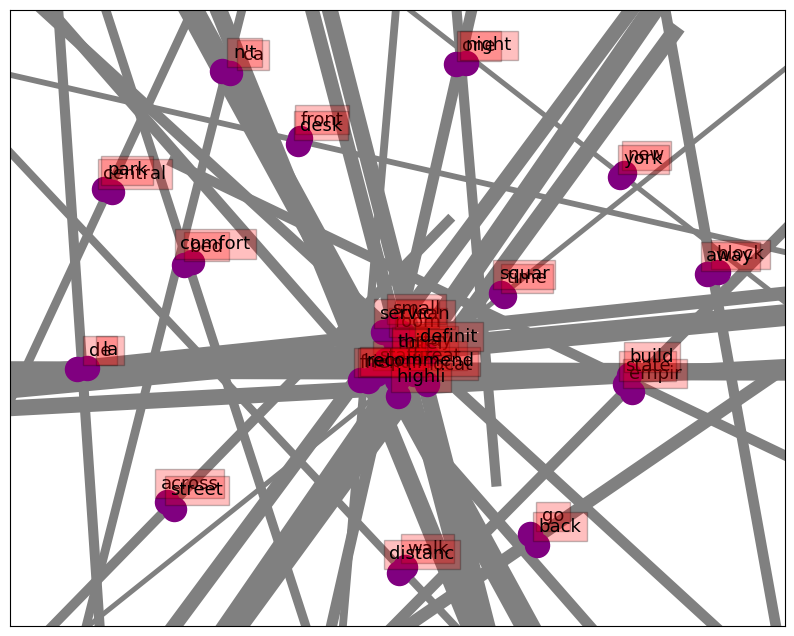

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 6. Pairwise correlation
6.1計算兩個詞彙間的相關性 Pearson correlation

In [9]:
data_cor = has_class_df.copy()

# 需要改成使用空格連接斷好的詞
data_cor["text"] = data_cor["text"].fillna("").astype(str)
data_cor['word'] = data_cor.text.apply(getToken).map(' '.join)
data_cor

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id_x,via_mobile,hotel_class,region_id,url,phone,details,address,type,id_y,name,word
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,stay king suit 11 night ye cot us bit happi st...
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,"December 17, 2012",147639004,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,everi visit nyc hotel beacon place love stay c...
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,"December 18, 2012",147697954,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue,thi great properti midtown two differ room dif...
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",August 2012,1762573,0,"December 17, 2012",147625723,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue,andaz nice hotel central locat manhattan hyatt...
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",December 2012,1762573,0,"December 17, 2012",147612823,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue,stay us andaz properti one best much better we...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843619,{'overall': 4.0},“vil komme igen”,"Pænt hotel i et livligt miljø. Store værelser,...","{'username': '', 'id': '', 'location': ''}",NaN,84093,0,"August 31, 2008",51441576,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel",pænt hotel et livligt miljø store værelser eno...
843620,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“excellent”,"un excellent hotel 4 *, pour un prix raisonnab...","{'username': 'dan016', 'num_reviews': 2, 'num_...",July 2008,84093,0,"July 18, 2008",18003332,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel",un excel hotel pour un prix raisonn un valet p...
843621,"{'cleanliness': 5.0, 'overall': 5.0, 'rooms': ...",“Un hotel eccezionale”,"L'hotel, situato in una zona tranquilla e a du...","{'username': '', 'id': '', 'location': ''}",July 2008,84093,0,"April 18, 2008",15564515,False,4.0,28970,http://www.tripadvisor.com/Hotel_Review-g28970...,NaN,NaN,"{'region': 'DC', 'street-address': '2121 P Str...",hotel,84093,"Palomar Washington DC, a Kimpton Hotel",l'hotel situato una zona tranquilla due passi ...
843622,"{'cleanliness': 5.0, 'overall': 5.0, 'rooms': ...",“Gerne wieder”,Sehr schön ausgestattetes Hotel in bester Lage...,"{'username': '', 'id': '', 'location': ''}",July 2008,84093,0,"April 1, 2008",15564508,False,4.0,28970,ht

In [ ]:
# 只取前 10000 筆資料（記憶體crash)
data_subset = data_cor.head(10000)

# Bag of Word：限制出現在至少 5 篇文章中，且僅取前 300 個高頻詞
vectorizer = CountVectorizer(min_df=5, max_features=300)
X = vectorizer.fit_transform(data_subset["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns=vocabulary, data=X.toarray())
DTM_df.head()


,10,abl,access,across,air,airport,also,although,alway,amaz,...,weekend,well,went,window,within,without,wonder,work,year,york
0,0,1,2,1,1,0,0,0,0,0,...,0,2,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,3,0,1,1,0,0,1,0,0
4,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [22]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,10,abl,access,across,air,airport,also,although,alway,...,weekend,well,went,window,within,without,wonder,work,year,york
0,10,1.000000,0.044801,0.058487,0.053483,0.042786,0.060771,0.106823,0.050384,0.038440,...,0.029789,0.070467,0.082149,0.046215,0.070912,0.044974,0.006441,0.070992,0.060643,0.032090
1,abl,0.044801,1.000000,0.052815,0.054117,0.039834,0.040190,0.118306,0.057021,0.049768,...,0.058266,0.078528,0.083136,0.060060,0.052984,0.075052,0.048148,0.077871,0.043278,0.017473
2,access,0.058487,0.052815,1.000000,0.059286,0.033358,0.053526,0.112349,0.062060,0.042633,...,0.027809,0.091608,0.028923,0.043981,0.059444,0.051032,0.019573,0.072935,0.031746,0.016182
3,across,0.053483,0.054117,0.059286,1.000000,0.036703,0.038472,0.128839,0.054077,0.044103,...,0.042363,0.082763,0.056352,0.073132,0.073028,0.037432,0.034504,0.054038,0.038138,0.017170
4,air,0.042786,0.039834,0.033358,0.036703,1.000000,0.028494,0.081849,0.054994,0.028357,...,0.010215,0.063033,0.059844,0.178317,0.030537,0.044283,0.008795,0.123216,0.025683,0.031990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,without,0.044974,0.075052,0.051032,0.037432,0.044283,0.033163,0.093019,0.056270,0.049342,...,0.036739,0.080850,0.075452,0.058197,0.046417,1.000000,0.036664,0.076260,0.048366,0.030408
296,wonder,0.006441,0.048148,0.019573,0.034504,0.008795,0.000613,0.071108,0.018302,0.063697,...,0.055741,0.067712,0.057822,0.028677,0.040061,0.036664,1.000000,0.034166,0.060605,0.022392
297,work,0.070992,0.077871,0.072935,0.054038,0.123216,0.042333,0.135818,0.070234,0.077415,...,0.038178,0.152795,0.131064,0.095645,0.045619,0.076260,0.034166,1.000000,0.069687,0.006909
298,year,0.060643,0.043278,0.031746,0.038138,0.025683,0.004504,0.074040,0.039087,0.114784,...,0.050946,0.074091,0.066659,0.039350,0.034484,0.048366,0.060605,0.069687,1.000000,0.036610


In [23]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
18873,und,die,0.792846
81962,die,und,0.792846
51599,york,new,0.790404
89871,new,york,0.790404
25044,le,et,0.777889
43283,et,le,0.777889
32760,desk,front,0.777127
18109,front,desk,0.777127
22173,und,ein,0.759122
81973,ein,und,0.759122


### 6.2 和 clean, service 相關性最高的 8 個詞彙

In [ ]:
d_sum = word_cor_df[(word_cor_df["word1"]=="clean")].sort_values(by=['cor'], ascending = False).head(8)
m_sum = word_cor_df[(word_cor_df["word1"]=="service")].sort_values(by=['cor'], ascending = False).head(8)

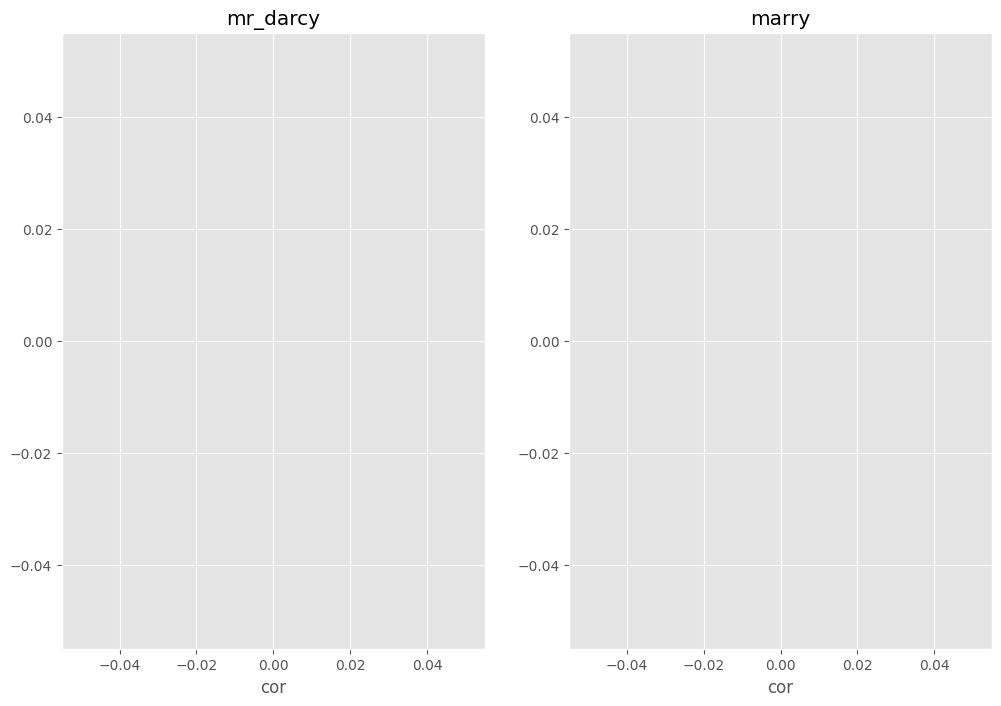

In [25]:
d_sum = d_sum.sort_values(by=['cor'])
m_sum = m_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
# plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示

plt.subplot(121)
plt.title('mr_darcy')
plt.xlabel('cor')
plt.barh(d_sum['word2'],d_sum['cor'])

plt.subplot(122)
plt.title('marry')
plt.xlabel('cor')
plt.barh(m_sum['word2'],m_sum['cor'],color="darkblue")


plt.show()

## 7. 計算章節相似度
以TF-IDF的結果當作章節的向量，計算 Cosine Similarity 找出相似的章節   

In [10]:
data_cos = data_cor.copy()
data_cos.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id_x,via_mobile,hotel_class,region_id,url,phone,details,address,type,id_y,name,word
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,"{'username': 'Papa_Panda', 'num_cities': 22, '...",December 2012,93338,0,"December 17, 2012",147643103,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,stay king suit 11 night ye cot us bit happi st...
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...","{'username': 'Maureen V', 'num_reviews': 2, 'n...",December 2012,93338,0,"December 17, 2012",147639004,False,3.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '2130 Broad...",hotel,93338,Hotel Beacon,everi visit nyc hotel beacon place love stay c...
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,"{'username': 'vuguru', 'num_cities': 12, 'num_...",December 2012,1762573,0,"December 18, 2012",147697954,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue,thi great properti midtown two differ room dif...
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,"{'username': 'Hotel-Designer', 'num_cities': 5...",August 2012,1762573,0,"December 17, 2012",147625723,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue,andaz nice hotel central locat manhattan hyatt...
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,"{'username': 'JamesE339', 'num_cities': 34, 'n...",December 2012,1762573,0,"December 17, 2012",147612823,False,4.0,60763,http://www.tripadvisor.com/Hotel_Review-g60763...,NaN,NaN,"{'region': 'NY', 'street-address': '485 5th Av...",hotel,1762573,Andaz 5th Avenue,stay us andaz properti one best much better we...


In [11]:
#crash
# 只取前 10000 筆資料（記憶體crash)
data_subset2 = data_cor.head(10000)
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_subset2["word"])
vocabulary = vectorizer.get_feature_names_out()
# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df.head()

,00,000,0000342,00a,00am,00p,00pm,01,02,0202,...,食事や買い物に困ることは一切ありませんでした,飲みに歩くのにも安全なところです,館内や室内は思っていた通り温かみのある可愛らしい内装でした,魚料理のほかピザやパスタがあって,１ｆのバーでは毎晩ジャズの生演奏が行われています,２００８年９月３０日宿泊でインターネットで予約を入れ,３階からは道路を挟んだ隣のビルのフードコートに直接歩いていける渡り廊下のようなものがあり,４泊しました,５千円,５泊しましたが
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
transformer = TfidfTransformer()  
# print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  
# print(tfidf.toarray())

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df.head()

計算飯店間的cosine similarity

In [ ]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

找和"飯店1"星等相似的其他飯店

In [ ]:
cos_df = pd.DataFrame(cosine_matrix[1], columns = ['cos_similarity'])
cos_df

In [ ]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity","chapter","sentence"]].sort_values(by=['cos_similarity'], ascending=False).head(10)